# Measurement uncertainty calculations

# Introduction

### Definitions
**Measurement uncertainty** is defined in the ISO ‘Guide to the Expression of Uncertainty in Measurement’ as ‘a parameter, associated with the result of a measurement that characterises the dispersion of the values that  could  reasonably  be  attributed  to  the  measurand’.  The  **measurand**  is  the  ‘quantity  intended  to  be measured’.

### Purpose
An estimate  of  uncertainty  provides  a  quantitative  indication  of  the  quality  of  a  measurement  result. Rather than using a ‘bottom-up’ approach which examines the inputs to a method and considers how they might influence results, the biochemical genetics units uses a ‘top-down’ approach using the information from method outputs (e.g. the observed variability of replicate measurement results), as described in ADD.BIO 6680: Estimating measurement uncertainty in the biochemical genetics unit. This notebook attempts to outline these steps.

## Imports, configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Optional Pandas configuration.

Since some columns have long names, change the maximum column width in Pandas so we can see the full name. We also may want to see the full list of rows, in some cases.


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

## Import mappings

The mappings file contains:
* a sort order for measurands within each assay
* a flag if the measurand is a ratio
* mappings to link the Assay and Measurand to the name of the QC material in [Randox Acusera 24:7](https://qc.randox.com/Acusera#Home)
* mappings to link the EQA scheme and EQA analyte name
* the lower and upper limit of quantitation, as described in the assay SOP. If the lower or upper limits are not specified in the SOP, these are given as 0 and 9999999 respectively. If more than one limit is provided (for example, different limits for different instruments), then the lower lower limit or higher upper limit was used.


In [3]:
mappings = pd.read_csv('data\\raw_data\\mappings.csv')
mappings.head()

,ID,Assay,Measurand,Order,IsRatio,ratio_numerator,ratio_denominator,Randox,Scheme name,EQA analyte name,reportable_range_lower,reportable_range_upper,reportable_range_source
0,Amino acids (CSF) - Glycine,Amino acids (CSF),Glycine,1,False,NaN,NaN,NaN,NaN,NaN,5.0,2000.0,ADD.BIO 66965 (v2.5)
1,Amino acids (CSF) - Serine,Amino acids (CSF),Serine,2,False,NaN,NaN,NaN,NaN,NaN,5.0,2000.0,ADD.BIO 66965 (v2.5)
2,Amino acids (Plasma) - Alanine,Amino acids (Plasma),Alanine,1,False,NaN,NaN,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,ERNDIM Amino Acids,Alanine,10.0,2000.0,ADD.BIO 66965 (v2.5)
3,Amino acids (Plasma) - Alloisoleucine,Amino acids (Plasma),Alloisoleucine,2,False,NaN,NaN,Alloisoleucine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,ERNDIM Amino Acids,Alloisoleucine,0.0,9999999.0,NaN
4,Amino acids (Plasma) - Arginine,Amino acids (Plasma),Arginine,3,False,NaN,NaN,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom,ERNDIM Amino Acids,Arginine,5.0,2000.0,ADD.BIO 66965 (v2.5)


# Obtain an estimate of the precision of the measurement procedure

## Load measurement uncertainty report from Randox Acusera 24:7

The measurement uncertainty report contains stiastics on each lot number in Randox Acusera. Data points that have been rejected are not included in the analysis.

When loading the data, merge with the mappings table and exclude QC lots where the measurand concentration is outside the reportable range

In [4]:
from functions import load_randox

In [5]:
qc_data = load_randox("data\\raw_data\\uncertainty_of_measurement_010120_311220.xlsx"
                        ,"data\\raw_data\\mappings.csv")

C:\Users\nickf\Desktop\Working from home\2021 - Measurement uncertainty\functions.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  randoxMU['Randox'][randoxMU['Lot Name'].str[:3] == 'AAU'] = randoxMU['Randox'].astype(str) + ' (Urine)'


## Obtain an estimate of the precision of the measurement procedure

The measurement uncertainty report from Randox needs to be processed to:
* exclude QC lots where the measurand concentration is outside the reportable range (done above when importing the data)
* exclude QC lots with low counts
* calculate averages for each measurand
* present the data by assay in a useful format

First,  create a summary for each lot number that shows some basic statistics by pivoting existing data and removing lots with low counts.

In [6]:
from functions import qc_lot_summary

In [7]:
qc_lot_summary(qc_data,'Organic acids', 10)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


GC-MSD2                    \
                                      OA2017.07                     
                                          Count   Mean   UOM % CV   
Measurand                                                           
Urine methylmalonate/creatinine ratio       101  34.64  1.97  5.7   
Urine orotate/creatinine ratio                                      

                                                                      
                                      SAU2018.2172                    
                                             Count   Mean   UOM % CV  
Measurand                                                             
Urine methylmalonate/creatinine ratio                                 
Urine orotate/creatinine ratio                  33  18.32  1.24  6.8

In [8]:
qc_lot_summary(qc_data,'Newborn screening for inherited metabolic disorders',10)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


4500MD                                                  \
                    2150L1                      2150L2                       
                     Count    Mean    UOM  % CV  Count    Mean    UOM % CV   
Measurand                                                                    
Leucines             102.0  165.78  11.49   6.9    102  509.46  26.68  5.2   
Methionine            95.0   16.72   1.86  11.1                              
Phenylalanine        100.0   92.37   5.72   6.2    100  763.94  51.21  6.7   
Tyrosine             100.0   79.08   6.35   8.0    101  621.84  42.98  6.9   
Isovalerylcarnitine  103.0    0.61   0.06   9.0    104    2.76   0.22  8.1   
Glutarylcarnitine    101.0    1.14   0.10   9.2                              
Octanoylcarnitine    102.0    0.48   0.04   7.8                              
Decanoylcarnitine    102.0    0.26   0.02   7.6    102    1.26   0.08  6.1   

                    API4000 NBS                                             \
                         2150L1                      2150L2                  
                          Count    Mean    UOM  % CV  Count    Mean    UOM   
Measurand                                                                    
Leucines                   32.0  259.92  17.13   6.6     32  802.21  53.76   
Methionine                 32.0   18.18   1.52   8.3                         
Phenylalanine              32.0   92.59   7.84   8.5     32  819.54  40.72   
Tyrosine                   32.0   83.01   6.26   7.5     32  642.87  25.18   
Isovalerylcarnitine        30.0    0.80   0.16  20.3     32    2.89   0.17   
Glutarylcarnitine          32.0    1.02   0.12  11.9                         
Octanoylcarnitine          31.0    0.41   0.03   7.6                         
Decanoylcarnitine          32.0    0.24   0.02   8.7     32    1.18   0.04   

                          
                          
                    % CV  
Measurand                 
Leucines             6.7  
Methionine                
Phenylalanine          5  
Tyrosine             3.9  
Isovalerylcarnitine  5.7  
Glutarylcarnitine         
Octanoylcarnitine         
Decanoylcarnitine    3.8

In [9]:
qc_lot_summary(qc_data,'Acylcarnitines (Blood spot)',10)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


API4000                     \
                                              2150L1                      
                                               Count   Mean   UOM  % CV   
Measurand                                                                 
Free carnitine                                    15  23.74  1.61   6.8   
C2 (Acetyl) carnitine                             15   6.68  0.32   4.7   
C3 (Propionyl) carnitine                          15   2.29  0.15   6.7   
C4 (Butyryl) Carnitine                            15   0.85  0.06   7.6   
C5 (Isovaleryl) Carnitine                         15   0.29   0.1  34.4   
C6 (Hexanoyl) Carnitine                           15    0.5  0.04   7.1   
C8 (Octanoyl) Carnitine                           15   0.44  0.04   8.9   
C10 (Decanoyl) Carnitine                          15   0.35  0.07  20.3   
C14 (Myristoyl) Carnitine                         15    0.5  0.03   6.4   
C16 (Palmitoyl) Carnitine                         15   1.34  0.11   8.4   
Hydroxybutyryl / malonyl carnitine                                        
Methylmalonyl  / Hydroxyisovaleryl carnitine      15   0.53  0.04   7.6   
Glutaryl carnitine                                15   0.87   0.1  11.7   
C10:1 carnitine                                                           
C12 carnitine                                     15    0.4  0.03   8.5   
C14:1 carnitine                                                           
Hydroxy C16 carnitine                                                     
C18:2 carnitine                                   15   0.27  0.03  10.6   
C18:1 carnitine                                   15   1.25  0.12   9.5   
C18 carnitine                                     15   0.67  0.04   6.6   
Hydroxy C18:1 carnitine                                                   
Hydroxy C18 carnitine                                                     
C3/C2 ratio                                                               
(C16 + C18:1)/C2 ratio                                                    

                                                                         
                                             2150L2                      
                                              Count    Mean   UOM  % CV  
Measurand                                                                
Free carnitine                                   15  112.87  7.24   6.4  
C2 (Acetyl) carnitine                            15   77.75  2.54   3.3  
C3 (Propionyl) carnitine                         15   13.62  0.73   5.4  
C4 (Butyryl) Carnitine                           15    7.28  0.33   4.5  
C5 (Isovaleryl) Carnitine                        15    2.21  0.19   8.5  
C6 (Hexanoyl) Carnitine                          15    1.35  0.09   6.7  
C8 (Octanoyl) Carnitine                          15    2.36  0.14   5.8  
C10 (Decanoyl) Carnitine                         15    1.42  0.08   5.6  
C14 (Myristoyl) Carnitine                        15    3.46  0.24   6.8  
C16 (Palmitoyl) Carnitine                        15   10.43  0.63   6.1  
Hydroxybutyryl / malonyl carnitine               15    0.11  0.01  11.9  
Methylmalonyl  / Hydroxyisovaleryl carnitine     15    0.68  0.06   8.2  
Glutaryl carnitine                               15    3.19  0.33  10.5  
C10:1 carnitine                                                          
C12 carnitine                                    15    5.68  0.34     6  
C14:1 carnitine                                                          
Hydroxy C16 carnitine                                                    
C18:2 carnitine                                  15    0.22  0.02  11.6  
C18:1 carnitine                                  15    0.73  0.07   9.9  
C18 carnitine                                    15    4.57  0.35   7.6  
Hydroxy C18:1 carnitine                                                  
Hydroxy C18 carnitine                                                    
C3/C2 ratio         

Next, we aggregate the data over all lots numbers and instruments (excluding those whe the count is less than the count threshold) by summing the total counts and averaging the measurement uncertainty and %CV.

In [10]:
from functions import qc_aggregated

In [11]:
qc_aggregated(qc_data,'Organic acids',10)

,Count,UOM,% CV
Measurand,,,
Urine methylmalonate/creatinine ratio,101,1.97,5.7
Urine orotate/creatinine ratio,33,1.24,6.8


In [12]:
qc_aggregated(qc_data,'Acylcarnitines (Blood spot)',10)

,Count,UOM,% CV
Measurand,,,
Free carnitine,30,4.425,6.6
C2 (Acetyl) carnitine,30,1.4255,4
C3 (Propionyl) carnitine,30,0.4435,6.05
C4 (Butyryl) Carnitine,30,0.198,6.05
C5 (Isovaleryl) Carnitine,30,0.144,21.45
C6 (Hexanoyl) Carnitine,30,0.0635,6.9
C8 (Octanoyl) Carnitine,30,0.0885,7.35
C10 (Decanoyl) Carnitine,30,0.0755,12.95
C14 (Myristoyl) Carnitine,30,0.134,6.6


We can then combine the lot statistics and aggregated statistics

In [13]:
from functions import qc_lot_summary_with_means

Note: for the acylcarnitines assay, some measurands have data for one QC lot, and some measurands have no values. This is because the measurand is present at less than the limit of quantitation

In [14]:
qc_lot_summary_with_means(qc_data, 'Newborn screening for inherited metabolic disorders', 10)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


4500MD                                                  \
                    2150L1                      2150L2                       
                     Count    Mean    UOM  % CV  Count    Mean    UOM % CV   
Measurand                                                                    
Leucines             102.0  165.78  11.49   6.9    102  509.46  26.68  5.2   
Methionine            95.0   16.72   1.86  11.1                              
Phenylalanine        100.0   92.37   5.72   6.2    100  763.94  51.21  6.7   
Tyrosine             100.0   79.08   6.35   8.0    101  621.84  42.98  6.9   
Isovalerylcarnitine  103.0    0.61   0.06   9.0    104    2.76   0.22  8.1   
Glutarylcarnitine    101.0    1.14   0.10   9.2                              
Octanoylcarnitine    102.0    0.48   0.04   7.8                              
Decanoylcarnitine    102.0    0.26   0.02   7.6    102    1.26   0.08  6.1   

                    API4000 NBS                                             \
                         2150L1                      2150L2                  
                          Count    Mean    UOM  % CV  Count    Mean    UOM   
Measurand                                                                    
Leucines                   32.0  259.92  17.13   6.6     32  802.21  53.76   
Methionine                 32.0   18.18   1.52   8.3                         
Phenylalanine              32.0   92.59   7.84   8.5     32  819.54  40.72   
Tyrosine                   32.0   83.01   6.26   7.5     32  642.87  25.18   
Isovalerylcarnitine        30.0    0.80   0.16  20.3     32    2.89   0.17   
Glutarylcarnitine          32.0    1.02   0.12  11.9                         
Octanoylcarnitine          31.0    0.41   0.03   7.6                         
Decanoylcarnitine          32.0    0.24   0.02   8.7     32    1.18   0.04   

                         All instrument                
                               All lots                
                    % CV          Count    UOM   % CV  
Measurand                                              
Leucines             6.7            268  27.26   6.35  
Methionine                          127   1.69   9.70  
Phenylalanine          5            264  26.37   6.60  
Tyrosine             3.9            265  20.19   6.57  
Isovalerylcarnitine  5.7            269   0.15  10.78  
Glutarylcarnitine                   133   0.11  10.55  
Octanoylcarnitine                   133   0.03   7.70  
Decanoylcarnitine    3.8            268   0.04   6.55

We can export the data for all assays as seperate .csv files which are saved in the \data\processed\qc_summary_tables folder

In [15]:
from functions import assay_qc_data_export

In [16]:
assay_qc_data_export(qc_data,10)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Amino acids (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Amino acids (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Biotinidase (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Acylcarnitines (Blood spot) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Immunoreactive trypsinogen (Blood spot) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Thyroid Stimulating Hormone (Blood spot) succesfully exported
Chitotriosidase (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Creatine and guanidinoacetate (Plasma) succesfully exported
Creatine and guanidinoacetate (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Total homocysteine (Plasma) succesfully exported
Newborn screening for inherited metabolic disorders succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Newborn screening for sickle cell disorders succesfully exported
Organic acids succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Chloride (Sweat) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Immunosuppressant drugs succesfully exported
5-hydroxyindoleacetic acid (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Glycosaminoglycans (Urine) succesfully exported
Metanephrines (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Porphobilinogen (Urine) succesfully exported
Sulfocysteine (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


VMA and HVA (Urine) succesfully exported
VLCFA (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (3 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


# Obtain an estimate of the measurement bias and its uncertainty

Measurement bias and its uncertainty can be estimnated from the regular participation in external quality assessment (EQA).

## Load and pre-processing EQA data

### Load EQA data

Load EQA results from a csv file (UKNEQAS results can be obtained using EQA data scraper)

In [17]:
from functions import load_eqa

In [18]:
folder = 'data//raw_data//eqa_results//results_targets'
eqa_results = load_eqa(folder)
eqa_results.head()

,Scheme name,Specimen,EQA analyte name,Result,Targ,n,Pool,Standard Uncertainty,Instrument
0,ERNDIM Amino Acids,2020.08,2-Aminobutyric acid,NaN,54,196.0,NaN,0.0,NaN
1,ERNDIM Amino Acids,2020.08,Alanine,602,559,267.0,NaN,0.0,NaN
2,ERNDIM Amino Acids,2020.08,Alloisoleucine,38,44,194.0,NaN,0.0,NaN
3,ERNDIM Amino Acids,2020.08,Arginine,174,164,266.0,NaN,0.0,NaN
4,ERNDIM Amino Acids,2020.08,Argininosuccinic acid,NaN,18,121.0,NaN,0.0,NaN


### Calculate EQA statistics

The EQA data does not contain the specimen bias or percentage uncertainty in the target. We can calculate these from the result, target value and standard uncertainty of the target value (after excluding non-numeric results and target values)

In [19]:
from functions import eqa_calculations

In [20]:
eqa_calculated = eqa_calculations(eqa_results)

### Exclude outliers

Let's have a look at any outliers, where the bias is 100% or more.

In [21]:
eqa_calculated[abs(eqa_calculated['% Bias']) >= 100]

,Scheme name,Specimen,EQA analyte name,n,Pool,Standard Uncertainty,Instrument,Result,Targ,% Bias,% uncertainty in target value
33,ERNDIM Amino Acids,2020.07,Alloisoleucine,181.0,NaN,0.00,NaN,2.000,0.0,inf,NaN
235,ERNDIM Amino Acids,2020.01,Methionine,277.0,NaN,0.00,NaN,85.000,11.0,672.7,0.0
1282,Birmingham Quality ~ Newborn British Isles,314C,C5,NaN,661,0.01,4000,0.200,0.1,100.0,10.0
1316,Birmingham Quality ~ Newborn British Isles,315A,C5DC,NaN,656,0.01,4000,0.070,0.0,inf,inf
1351,Birmingham Quality ~ Newborn British Isles,316C,C5DC,NaN,664,0.04,4000,71.000,0.9,7788.9,4.4
1400,Birmingham Quality ~ Newborn British Isles,318A,Initial C8,NaN,671,0.00,4000,0.030,0.0,inf,NaN
1403,Birmingham Quality ~ Newborn British Isles,318A,Final C8,NaN,671,0.00,4000,0.030,0.0,inf,NaN
1406,Birmingham Quality ~ Newborn British Isles,318A,C10,NaN,671,0.00,4000,0.032,0.0,inf,NaN
1412,Birmingham Quality ~ Newborn British Isles,318A,C5,NaN,671,0.00,4000,0.100,0.0,inf,NaN
1415,Birmingham Quality ~ Newborn British Isles,318A,C5DC,NaN,671,0.01,4000,0.050,0.0,inf,inf


Exclude these outliers since they are all either target values of 0, transcription errors on EQA submission, or known interference (for methionine on plasma EQA scheme)

In [22]:
eqa_calculated = eqa_calculated[abs(eqa_calculated['% Bias']) < 100]

Now let's see any outliers with an absolute bias of > 75%. Let's leave them in for now.

In [23]:
eqa_calculated[abs(eqa_calculated['% Bias']) >= 75]

,Scheme name,Specimen,EQA analyte name,n,Pool,Standard Uncertainty,Instrument,Result,Targ,% Bias,% uncertainty in target value
1345,Birmingham Quality ~ Newborn British Isles,316C,C8/C10 ratio,NaN,664,0.010,4000,0.19,0.10,90.0,10.0
1376,Birmingham Quality ~ Newborn British Isles,317A,C8/C10 ratio,NaN,665,0.000,4000,0.18,0.10,80.0,0.0
1445,Birmingham Quality ~ Newborn British Isles,319A,C5,NaN,659,0.010,4000,0.10,0.40,-75.0,2.5
1925,Birmingham Quality ~ Newborn British Isles,319A,C5,NaN,659,0.010,4500,0.10,0.40,-75.0,2.5
1969,Birmingham Quality ~ Newborn British Isles,320C,C8/C10 ratio,NaN,664,0.000,4500,0.19,0.10,90.0,0.0
2012,Birmingham Quality ~ Newborn British Isles,321A,C8/C10 ratio,NaN,665,0.010,4500,0.19,0.10,90.0,10.0
2218,WEQAS Porphyrin,A93-3,Quantitative PBG,NaN,NaN,0.257,NaN,2.90,1.55,87.1,16.6


### Merge data with assay names and measurands

Merge the data with the mappings file, since the EQA schemes don't correspond with the assay names.

In [24]:
eqa_data = mappings.merge(right=eqa_calculated,on=['Scheme name','EQA analyte name'],how='outer')

## Plot bias against target value

Next plot the data to see if bias varies with target value. This can be done either individually, or for all assays in the EQA data.

First plot for a single EQA scheme:

In [25]:
from functions import eqa_assay_bias_plot

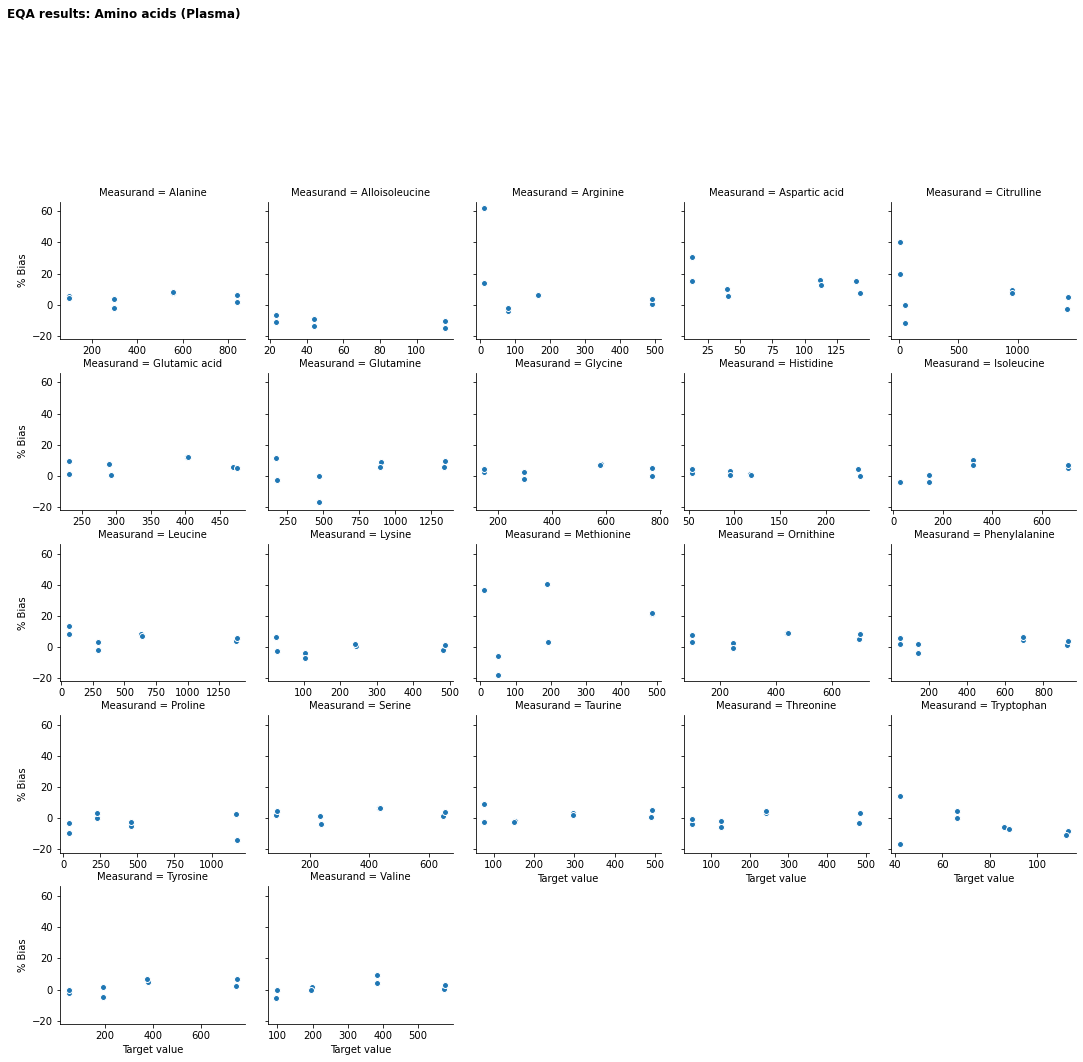

In [26]:
eqa_assay_bias_plot(eqa_data,'Amino acids (Plasma)')

Next, plot for all assays in the eqa data

In [27]:
from functions import eqa_bias_multi_plot

In [28]:
#eqa_bias_multi_plot(eqa_data)
# skip for now as takes a while

## Calculate EQA summary statistics

Now we can calculate aggregate statistics across all specimens and distributions. This assumes that the %bias is constant throughout the measurable range (may not be true, although the previous plots will give an indication of how valid this assumption is).

In [29]:
from functions import eqa_summary_statistics

In [30]:
eqa_data.head()

,ID,Assay,Measurand,Order,IsRatio,ratio_numerator,ratio_denominator,Randox,Scheme name,EQA analyte name,...,reportable_range_source,Specimen,n,Pool,Standard Uncertainty,Instrument,Result,Targ,% Bias,% uncertainty in target value
0,Amino acids (CSF) - Glycine,Amino acids (CSF),Glycine,1.0,False,NaN,NaN,NaN,NaN,NaN,...,ADD.BIO 66965 (v2.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Amino acids (CSF) - Serine,Amino acids (CSF),Serine,2.0,False,NaN,NaN,NaN,NaN,NaN,...,ADD.BIO 66965 (v2.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amino acids (Urine) - Alanine,Amino acids (Urine),Alanine,1.0,False,NaN,NaN,Alanine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (Urine),NaN,NaN,...,ADD.BIO 66965 (v2.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amino acids (Urine) - Arginine,Amino acids (Urine),Arginine,2.0,False,NaN,NaN,Arginine Clinical Chemistry Cation exchange chromatography umol/l Biochrom (Urine),NaN,NaN,...,ADD.BIO 66965 (v2.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amino acids (Urine) - Aspartic acid,Amino acids (Urine),Aspartic acid,3.0,False,NaN,NaN,Aspartate Clinical Chemistry Cation exchange chromatography umol/l Biochrom (Urine),NaN,NaN,...,ADD.BIO 66965 (v2.5),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
eqa_stats = eqa_summary_statistics(eqa_data,'Newborn screening for inherited metabolic disorders')
eqa_stats

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Specimen  Targ         % Bias        \
                       count   min     max   mean   std   
Measurand                                                 
Leucines                  60  89.0   654.0   -1.9  16.3   
Methionine                60   5.0    86.0  -17.2  12.9   
Phenylalanine             60  34.0  1679.0    2.7  10.5   
Tyrosine                  60  37.0  1557.0    1.6   7.3   
Isovalerylcarnitine       52   0.1     2.5    7.4  26.6   
Glutarylcarnitine         54   0.3     2.1   -6.1  16.8   
Octanoylcarnitine         55   0.1     2.8    3.1  17.9   
Decanoylcarnitine         55   0.2     5.7    6.7  10.8   

                    % uncertainty in target value  \
                                             mean   
Measurand                                           
Leucines                                      2.8   
Methionine                                    3.9   
Phenylalanine                                 2.8   
Tyrosine                                      2.7   
Isovalerylcarnitine                           3.6   
Glutarylcarnitine                             3.8   
Octanoylcarnitine                             4.2   
Decanoylcarnitine                             3.7   

                    Combined uncertainty of % bias  \
                                                     
Measurand                                            
Leucines                                      16.5   
Methionine                                    13.5   
Phenylalanine                                 10.9   
Tyrosine                                       7.8   
Isovalerylcarnitine                           26.9   
Glutarylcarnitine                             17.2   
Octanoylcarnitine                             18.3   
Decanoylcarnitine                             11.4   

                    Expanded uncertainty of % bias  
                                                    
Measurand                                           
Leucines                                      33.0  
Methionine                                    27.0  
Phenylalanine                                 21.7  
Tyrosine                                      15.5  
Isovalerylcarnitine                           53.8  
Glutarylcarnitine                             34.5  
Octanoylcarnitine                             36.7  
Decanoylcarnitine                             22.8

If there is no quantitative EQA scheme (like for acylcarnitines), the table will be blank

In [32]:
eqa_stats = eqa_summary_statistics(eqa_data,'Acylcarnitines (Blood spot)')
eqa_stats

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Specimen Targ     % Bias      \
                                                count  min max   mean std   
Measurand                                                                   
Free carnitine                                      0                       
C2 (Acetyl) carnitine                               0                       
C3 (Propionyl) carnitine                            0                       
C4 (Butyryl) Carnitine                              0                       
C5 (Isovaleryl) Carnitine                           0                       
C6 (Hexanoyl) Carnitine                             0                       
C8 (Octanoyl) Carnitine                             0                       
C10 (Decanoyl) Carnitine                            0                       
C14 (Myristoyl) Carnitine                           0                       
C16 (Palmitoyl) Carnitine                           0                       
Hydroxybutyryl / malonyl carnitine                  0                       
Methylmalonyl  / Hydroxyisovaleryl carnitine        0                       
Glutaryl carnitine                                  0                       
C10:1 carnitine                                     0                       
C12 carnitine                                       0                       
C14:1 carnitine                                     0                       
Hydroxy C16 carnitine                               0                       
C18:2 carnitine                                     0                       
C18:1 carnitine                                     0                       
C18 carnitine                                       0                       
Hydroxy C18:1 carnitine                             0                       
Hydroxy C18 carnitine                               0                       
C3/C2 ratio                                         0                       
(C16 + C18:1)/C2 ratio                              0                       

                                             % uncertainty in target value  \
                                                                      mean   
Measurand                                                                    
Free carnitine                                                               
C2 (Acetyl) carnitine                                                        
C3 (Propionyl) carnitine                                                     
C4 (Butyryl) Carnitine                                                       
C5 (Isovaleryl) Carnitine                                                    
C6 (Hexanoyl) Carnitine                                                      
C8 (Octanoyl) Carnitine                                                      
C10 (Decanoyl) Carnitine                                                     
C14 (Myristoyl) Carnitine                                                    
C16 (Palmitoyl) Carnitine                                                    
Hydroxybutyryl / malonyl carnitine                                           
Methylmalonyl  / Hydroxyisovaleryl carnitine                                 
Glutaryl carnitine                                                           
C10:1 carnitine                                                              
C12 carnitine                                                                
C14:1 carnitine                                                              
Hydroxy C16 carnitine                                                        
C18:2 carnitine                                                              
C18:1 carnitine                                                              
C18 carnitine                                                                
Hydroxy C18:1 carnitine                                                      
Hydroxy C18 carnitine                                                        
C3/C2 ratio    

We can export the data for all assays as seperate .csv files which are saved in the \data\processed\eqa_summary_tables folder

In [33]:
from functions import assay_eqa_data_export

In [34]:
assay_eqa_data_export(eqa_data)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Amino acids (CSF) succesfully exported
Amino acids (Urine) succesfully exported
Acylcarnitines (Blood spot) succesfully exported
Chitotriosidase (Plasma) succesfully exported
Creatine and guanidinoacetate (Plasma) succesfully exported
Creatine and guanidinoacetate (Urine) succesfully exported
Newborn screening for sickle cell disorders succesfully exported
Glycosaminoglycans (Urine) succesfully exported
pH (Urine) succesfully exported
Porphobilinogen (Urine) succesfully exported
Sulfocysteine (Urine) succesfully exported
VMA and HVA (Urine) succesfully exported
VLCFA (Plasma) succesfully exported
Amino acids (Plasma) succesfully exported
Biotinidase (Plasma) succesfully exported
Immunoreactive trypsinogen (Blood spot) succesfully exported
Thyroid Stimulating Hormone (Blood spot) succesfully exported
Total homocysteine (Plasma) succesfully exported
Newborn screening for inherited metabolic disorders succesfully exported
Organic acids succesfully exported
Chloride (Sweat) succesfully exp

# Performance targets

Performance targets for each measurand are detailed in **ADD.BIO 6378**: *BGU Quality Monitoring Processes (Appendix 4)*

Import the performance targets, rename the columns and round to one decimal place.

In [35]:
from functions import load_performance_targets

In [36]:
performance_targets = load_performance_targets('data//raw_data/performance_targets_january_2021.xlsx')
performance_targets.head()

,Assay,Measurand,Anal CV Optimal,Anal CV Desirable,Anal CV Minimal,Bias Optimal,Bias Desirable,Bias Minimal,TE Optimal,TE Desirable,TE Minimal
0,Amino acids (CSF),Glycine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
1,Amino acids (CSF),Serine,5.0,10.0,15.0,5.0,10.0,15.0,13.2,26.5,39.8
2,Amino acids (Plasma),Alanine,3.7,7.4,11.0,7.2,14.4,21.6,13.3,26.6,39.8
3,Amino acids (Plasma),Alloisoleucine,3.9,7.8,11.6,6.0,12.0,18.0,12.4,24.8,37.2
4,Amino acids (Plasma),Arginine,4.8,9.6,14.5,4.9,9.8,14.7,12.9,25.7,38.6


Performance against imprecision, bias and total allowable error is assessed against three targets:
* Optimal
* Desirable
* Minimal

In [37]:
from functions import performance_table

In [38]:
performance_table(qc_data, eqa_data, 'Acylcarnitines (Blood spot)', 10, performance_targets)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,% CV,CV performance,% Bias,Bias performance,Total error,TAE performance
Measurand,,,,,,
Free carnitine,6.6,Desirable,,,,
C2 (Acetyl) carnitine,4,Optimal,,,,
C3 (Propionyl) carnitine,6.05,Desirable,,,,
C4 (Butyryl) Carnitine,6.05,Desirable,,,,
C5 (Isovaleryl) Carnitine,21.45,Not met,,,,
C6 (Hexanoyl) Carnitine,6.9,Desirable,,,,
C8 (Octanoyl) Carnitine,7.35,Desirable,,,,
C10 (Decanoyl) Carnitine,12.95,Minimal,,,,
C14 (Myristoyl) Carnitine,6.6,Desirable,,,,


In [39]:
performance_table(qc_data, eqa_data, 'Amino acids (Plasma)', 10, performance_targets)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,% CV,CV performance,% Bias,Bias performance,Total error,TAE performance
Measurand,,,,,,
Alanine,3.50,Optimal,3.3,Optimal,9.1,Optimal
Alloisoleucine,3.20,Optimal,2.9,Optimal,8.2,Optimal
Arginine,5.55,Desirable,21.5,Not met,30.7,Minimal
Aspartic acid,5.45,Optimal,7.7,Optimal,16.7,Optimal
Citrulline,5.05,Optimal,15.7,Minimal,24.0,Desirable
Glutamic acid,6.85,Optimal,4.6,Optimal,15.9,Optimal
Glutamine,4.80,Desirable,9.2,Minimal,17.1,Minimal
Glycine,3.90,Desirable,3.4,Optimal,9.8,Optimal
Histidine,4.10,Desirable,1.8,Optimal,8.6,Desirable


In [40]:
from functions import assay_performance_data_export

In [41]:
assay_performance_data_export(qc_data, eqa_data, 10, performance_targets)

C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


!!! Error in exporting data for Amino acids (Plasma)


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Amino acids (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Biotinidase (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Acylcarnitines (Blood spot) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Immunoreactive trypsinogen (Blood spot) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Thyroid Stimulating Hormone (Blood spot) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Chitotriosidase (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Creatine and guanidinoacetate (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Creatine and guanidinoacetate (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Total homocysteine (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Newborn screening for inherited metabolic disorders succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Newborn screening for sickle cell disorders succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Organic acids succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Chloride (Sweat) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Immunosuppressant drugs succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


5-hydroxyindoleacetic acid (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Glycosaminoglycans (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Metanephrines (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Porphobilinogen (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Sulfocysteine (Urine) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


VMA and HVA (Urine) succesfully exported
VLCFA (Plasma) succesfully exported


C:\Users\nickf\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
